# HAR LSTM Assignment

In [26]:
# Importing Libraries
import pandas as pd
import numpy as np
import scipy

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
session = InteractiveSession(config=config)

import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.layers import Dropout,Flatten,Conv1D
from keras.layers import Dense
from sklearn.metrics import accuracy_score

from keras.callbacks import EarlyStopping, CSVLogger, TensorBoard,ReduceLROnPlateau

C:\Users\family\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [27]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [28]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [29]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [30]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [31]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [32]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [33]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\family\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\Users\family\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


## 1. Simple 2 layer LSTM

In [79]:
# Initiliazing the sequential model
model = Sequential()

# Configuring the parameters

# 1st Layer of LSTM
model.add(LSTM(128, input_shape=(128, 9),return_sequences=True,kernel_initializer='glorot_normal'))
# Adding a dropout layer
model.add(Dropout(0.2))

# 2nd Layer of LSTM
model.add(LSTM(64,kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))

# Adding a dense output layer with sigmoid activation
model.add(Dense(6, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 128)          70656     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 120,454
Trainable params: 120,454
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=75,
          validation_data=(X_test, Y_test),epochs=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 22s 3ms/step - loss: 1.2818 - accuracy: 0.4702 - val_loss: 1.1241 - val_accuracy: 0.5073
Epoch 2/100
7352/7352 [==============================] - 22s 3ms/step - loss: 0.9431 - accuracy: 0.5861 - val_loss: 0.8120 - val_accuracy: 0.6817
Epoch 3/100
7352/7352 [==============================] - 22s 3ms/step - loss: 0.7796 - accuracy: 0.6733 - val_loss: 0.7196 - val_accuracy: 0.6899
Epoch 4/100
7352/7352 [==============================] - 21s 3ms/step - loss: 0.6075 - accuracy: 0.7582 - val_loss: 0.5810 - val_accuracy: 0.7496
Epoch 5/100
7352/7352 [==============================] - 22s 3ms/step - loss: 0.4916 - accuracy: 0.7904 - val_loss: 0.5486 - val_accuracy: 0.7706
Epoch 6/100
7352/7352 [==============================] - 21s 3ms/step - loss: 0.4150 - accuracy: 0.8271 - val_loss: 0.5966 - val

In [81]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  0      394        95        0                   0   
STANDING                 0       83       449        0                   0   
WALKING                  0        0         0      470                  14   
WALKING_DOWNSTAIRS       0        0         0        1                 419   
WALKING_UPSTAIRS         0        0         0        5                  12   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            2  
STANDING                           0  
WALKING                           12  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                 454  


In [82]:
score = model.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 9s 3ms/step


[0.24532297056183483, 0.9239904880523682]

## 2.   1-D CNN followed by 2 layer Bidirectional LSTM

In [9]:
n_classes=6

# Initiliazing the sequential model
model = Sequential()

# Configuring the parameters
#CNN
model.add(keras.layers.Conv1D(filters=32,kernel_size=(1),strides=1,padding='valid',activation='relu'))
model.add(Dropout(0.5))

# 1st Layer of LSTM
model.add(keras.layers.Bidirectional(LSTM(32,return_sequences=True,kernel_initializer='glorot_normal')))
# Adding a dropout layer
model.add(Dropout(0.5))

#LSTM
model.add(keras.layers.Bidirectional(LSTM(10 ,kernel_initializer='glorot_normal')))      
model.add(Dropout(0.5))

#DENSE
model.add(Dense(28,activation='relu'))
          
# Adding a dense output layer with sigmoid activation     
model.add(Dense(n_classes, activation='sigmoid'))

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

In [142]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=100,
          validation_data=(X_test, Y_test),
          epochs=100)

Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 26s 4ms/step - loss: 0.1460 - accuracy: 0.9430 - val_loss: 0.3804 - val_accuracy: 0.8955
Epoch 2/100
7352/7352 [==============================] - 26s 4ms/step - loss: 0.1587 - accuracy: 0.9391 - val_loss: 0.4085 - val_accuracy: 0.8921
Epoch 3/100
7352/7352 [==============================] - 26s 4ms/step - loss: 0.1525 - accuracy: 0.9431 - val_loss: 0.3362 - val_accuracy: 0.8982
Epoch 4/100
7352/7352 [==============================] - 26s 4ms/step - loss: 0.1392 - accuracy: 0.9471 - val_loss: 0.3751 - val_accuracy: 0.8985
Epoch 5/100
7352/7352 [==============================] - 26s 3ms/step - loss: 0.1381 - accuracy: 0.9456 - val_loss: 0.3014 - val_accuracy: 0.9030
Epoch 6/100
7352/7352 [==============================] - 26s 4ms/step - loss: 0.1395 - accuracy: 0.9434 - val_loss: 0.3216 - val_accuracy: 0.9141
Epoch 7/100
7352/7352 [==============================] - 26s 3ms/step - loss

In [143]:
score = model.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 14s 5ms/step


[0.42743501546085205, 0.917203962802887]

### Observation ...


# 3. Divide and Conquer method 

#### refer: https://www.mdpi.com/1424-8220/18/4/1055
#### refer: https://github.com/heeryoncho/sensors2018cnnhar

#### From paper:

        "Our approach is similar to [36] in that we perform a two-stage classification where we classify
        abstract activities (e.g., dynamic and static) first and then classify individual activities (e.g., walking,
        standing, etc.) next. However, we build one binary 1D CNN model at the first stage and two multi-class
        1D CNN models at the second stage. More importantly, we introduce test data sharpening in between
        the two-stage HAR, selectively at the prediction phase only, and this differentiates our approach from
        the rest of the two-stage HAR approaches."

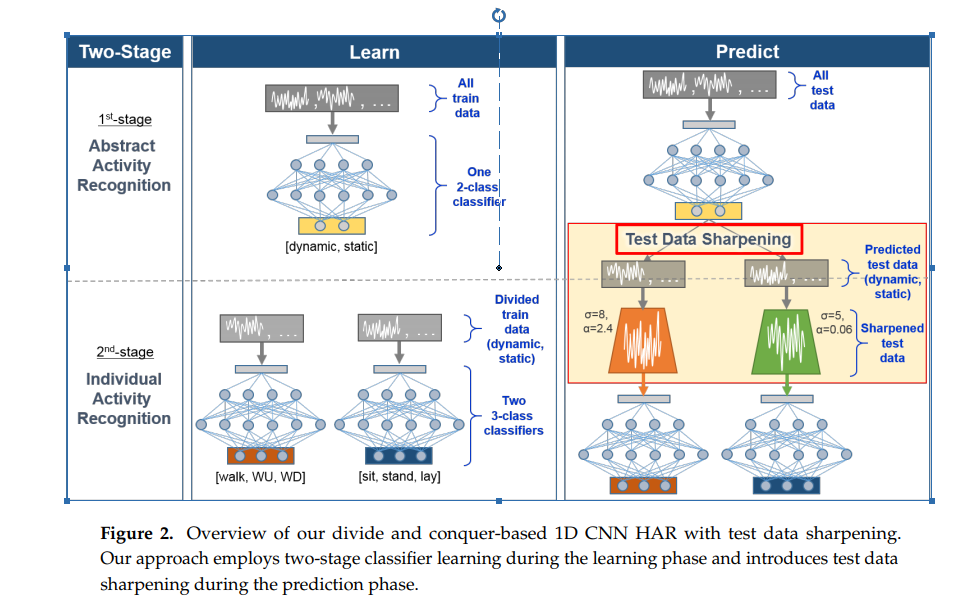

In [34]:
# refer: https://www.mdpi.com/1424-8220/18/4/1055
# refer: https://github.com/heeryoncho/sensors2018cnnhar

from IPython.display import Image
Image(filename='divide and conquer.PNG')


In [35]:
#utility function
# decoding y_tain(6 class) into {0,1,2,3,4,5,9}
def amax(num):
    return (np.argmax(num))

y_train_decode=pd.DataFrame(Y_train).apply(amax,axis=1)
y_test_decode=pd.DataFrame(Y_test).apply(amax,axis=1)

print("Before: ")
print(Y_train)
print("\nAfter: ")
print(y_train_decode)

Before: 
[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 ...
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]]

After: 
0       4
1       4
2       4
3       4
4       4
       ..
7347    1
7348    1
7349    1
7350    1
7351    1
Length: 7352, dtype: int64


C:\Users\family\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


In [36]:
# utility function
def binary_decode(num):
    if np.argmax(num)<3:
        return 0
    else:
        return 1

### 3.1 Model for static and dynamic binary classification

In [37]:
# model for static and dynamic binary classification
def train_2_class_classifiation():
    
    # mode configuration
    model = Sequential()
    model.add(Conv1D(128, 3, input_shape=(128, 9), activation='relu'))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    model.add(Dropout(0.50))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    # Summarize layers
    print(model.summary())
    return model

train_2_class_classifiation()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 126, 128)          3584      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 124, 64)           24640     
_________________________________________________________________
flatten_5 (Flatten)          (None, 7936)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 15874     
_________________________________________________________________
dropout_5 (Dropout)          (None, 2)                 0         
Total params: 44,098
Trainable params: 44,098
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
# preparing data for static and dynamic binary classification

# this will convert y_train and y_test into {0,1}
y_train_binary= pd.DataFrame(Y_train).apply(binary_decode,axis=1) 
y_test_binary= pd.DataFrame(Y_test).apply(binary_decode,axis=1) 

# one hot encoding of decoded y_train and y_test
y_train_static_dynamic_oh = keras.utils.to_categorical(y_train_binary) 
y_test_static_dynamic_oh = keras.utils.to_categorical(y_test_binary) # one hot encoding of decoded y_test


# Traning tatic and dynamic  binary classification
binary_model = train_2_class_classifiation()
binary_model.fit(X_train, y_train_static_dynamic_oh,
             batch_size=32, epochs=15, verbose=2, validation_data=(X_test,y_test_static_dynamic_oh) )


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 126, 128)          3584      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 124, 64)           24640     
_________________________________________________________________
flatten_6 (Flatten)          (None, 7936)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 15874     
_________________________________________________________________
dropout_6 (Dropout)          (None, 2)                 0         
Total params: 44,098
Trainable params: 44,098
Non-trainable params: 0
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/15
 - 2s - loss: 0.3890 - accuracy: 0.6094 - val_loss: 

In [39]:
binary_model.evaluate(X_test,y_test_static_dynamic_oh)

2947/2947 [==============================] - 0s 74us/step


[0.06440044102560151, 0.9989820122718811]

### 3.2 Model for Dynamic HAR

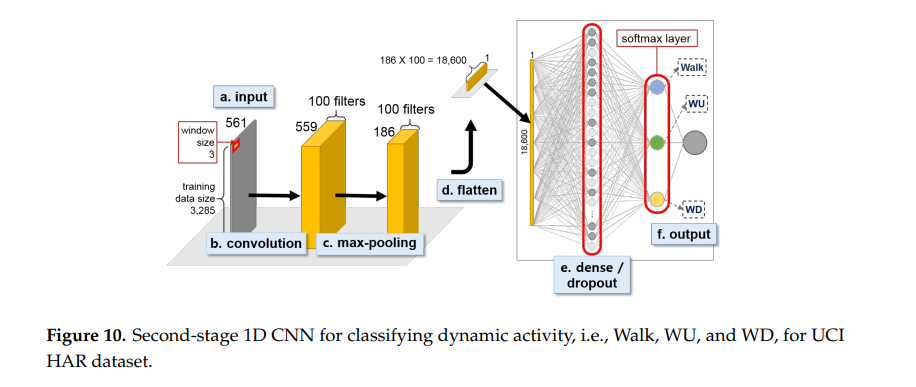

In [40]:
# refer: https://www.mdpi.com/1424-8220/18/4/1055
# refer: https://github.com/heeryoncho/sensors2018cnnhar

from IPython.display import Image
Image(filename='dynamic model.PNG')

In [41]:
# 1d CNN for dynamic HAR
def train_dyanamic():
    model = Sequential()
    model.add(Conv1D(100, 3, input_shape=(128, 9), activation='relu'))
    model.add(keras.layers.MaxPooling1D(3))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    model.add(Dropout(0.5))

    adam = keras.optimizers.Adam(lr=0.0004, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

    model.summary()
    
    return model

In [42]:
# preparing traning data for dynamic 3-class classification

# Index of dynamic activity
dynamic_0=np.where(y_train_decode==0)[0]
dynamic_1=np.where(y_train_decode==1)[0]
dynamic_2=np.where(y_train_decode==2)[0]

dynamic_index=np.concatenate((dynamic_0,dynamic_1,dynamic_2),axis=0)

x_train_dyanamic=X_train[dynamic_index]
y_train_dynamic=y_train_decode[dynamic_index]
print("Total number of dynamic_traning data:",dynamic_index.shape[0])


# preparing test data
# Index of dynamic activity
dynamic_0=np.where(y_test_decode==0)[0]
dynamic_1=np.where(y_test_decode==1)[0]
dynamic_2=np.where(y_test_decode==2)[0]

dynamic_index=np.concatenate((dynamic_0,dynamic_1,dynamic_2))

x_test_dyanamic=X_test[dynamic_index]
y_test_dynamic=y_test_decode[dynamic_index]
print("Total number of dynamic_testing data:",dynamic_index.shape[0])


# Convert to one hot encoding vector
y_train_dynamic_oh = keras.utils.to_categorical(y_train_dynamic)                             
y_test_dynamic_oh = keras.utils.to_categorical(y_test_dynamic)

Total number of dynamic_traning data: 3285
Total number of dynamic_testing data: 1387


In [43]:

# Early Stopper callback
early_stopper = EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=10,verbose=1,
                              mode='auto',baseline=None,restore_best_weights=True)

dynamic_model=train_dyanamic()
dynamic_model.fit(x_train_dyanamic, y_train_dynamic_oh,
             batch_size=32, epochs=50, verbose=2, validation_data=(x_test_dyanamic,y_test_dynamic_oh),callbacks=[early_stopper] )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 126, 100)          2800      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 42, 100)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4200)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 12603     
_________________________________________________________________
dropout_7 (Dropout)          (None, 3)                 0         
Total params: 15,403
Trainable params: 15,403
Non-trainable params: 0
_________________________________________________________________
Train on 3285 samples, validate on 1387 samples
Epoch 1/50
 - 1s - loss: 0.3150 - accuracy: 0.4180 - val_loss: 0.186

In [44]:
dynamic_model.evaluate(x_test_dyanamic,y_test_dynamic_oh)

1387/1387 [==============================] - 0s 58us/step


[0.08977583711181257, 0.9639509916305542]

### 3.3 Model for static HAR

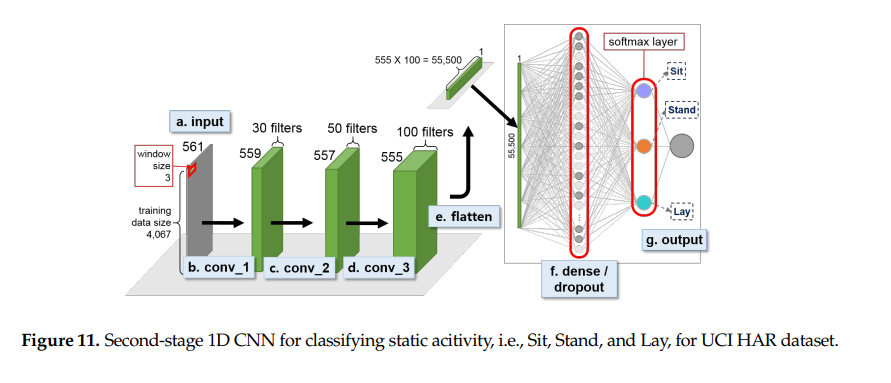

In [45]:
# refer: https://www.mdpi.com/1424-8220/18/4/1055
# refer: https://github.com/heeryoncho/sensors2018cnnhar

from IPython.display import Image
Image(filename='static model.PNG')

In [46]:
# model for static HAR
def train_static():

    model = Sequential()
    model.add(Conv1D(30, 3, input_shape=(128, 9), activation='relu'))
    model.add(Conv1D(50, 3, activation='relu'))
    model.add(Conv1D(100, 3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    model.add(Dropout(0.50))

    adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

    # Summarize layers
    print(model.summary())  
    return model

In [47]:
# preparing data for STATIC 3-class classification

# Index of static activity train data
static_0=np.where(y_train_decode==3)[0]
static_1=np.where(y_train_decode==4)[0]
static_2=np.where(y_train_decode==5)[0]
static_index=np.concatenate((static_0, static_1, static_2),axis=0)

# X_train_static, y_train_static
x_train_static=X_train[static_index]
y_train_static=y_train_decode[static_index]
print("Total number of static_traning data:",static_index.shape[0])


# Index of static activity test data
static_0=np.where(y_test_decode==3)[0]
static_1=np.where(y_test_decode==4)[0]
static_2=np.where(y_test_decode==5)[0]
static_index=np.concatenate((static_0, static_1, static_2) )
print("Total number of static_traning data:",static_index.shape[0])

# X_test_static, y_test_static
x_test_static=X_test[static_index]
y_test_static=y_test_decode[static_index]

# labeling class_labes from {3,4,5} to {0,1,2} for traning 
y_train_static=y_train_static.map({3:0, 4:1, 5:2})
y_test_static=y_test_static.map({3:0, 4:1, 5:2})

# Convert to one hot encoding vector
y_train_static_oh = keras.utils.to_categorical(y_train_static)
y_test_static_oh = keras.utils.to_categorical(y_test_static)


Total number of static_traning data: 4067
Total number of static_traning data: 1560


In [48]:
# Early Stopper callback
early_stopper = EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=10,verbose=1,
                              mode='auto',baseline=None,restore_best_weights=True)

static_model=train_static()
static_model.fit(x_train_static, y_train_static_oh,
             batch_size=32, epochs=50, verbose=2, validation_data=(x_test_static,y_test_static_oh) ,callbacks=[early_stopper]  )

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 126, 30)           840       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 124, 50)           4550      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 122, 100)          15100     
_________________________________________________________________
flatten_8 (Flatten)          (None, 12200)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 36603     
_________________________________________________________________
dropout_8 (Dropout)          (None, 3)                 0         
Total params: 57,093
Trainable params: 57,093
Non-trainable params: 0
__________________________________________________

In [49]:
static_model.evaluate(x_test_static,y_test_static_oh)

1560/1560 [==============================] - 0s 60us/step


[0.09011286143691112, 0.8852564096450806]

## Testing

In [50]:
# Execute this after executiong binary, static and dynamic classification traning is complete
def testing(x_test, y_test):
    
    # Binary class prediction
    predict_y_test_binary=binary_model.predict_classes(x_test) 
    
    
    # Static 1-D CNN 3-class prediction
    static_prediction_index = np.where(predict_y_test_binary==1)
    predict_y_test_static = static_model.predict_classes(x_test[static_prediction_index]) # for static
    predict_y_test_static = pd.Series(predict_y_test_static).map({0:3,1:4,2:5})
    
     # Dynamic 1-D CNN 3-class prediction
    dynamic_prediction_index = np.where(predict_y_test_binary==0)
    predict_y_test_dynamic=  dynamic_model.predict_classes(x_test[dynamic_prediction_index]) # for dynamic 
    
    # Modify the value of prediction od dynamic and static activity 
    y_test_pred_generated = np.zeros((x_test.shape[0]))
    y_test_pred_generated[static_prediction_index] = predict_y_test_static
    y_test_pred_generated[dynamic_prediction_index] = predict_y_test_dynamic
    
    # converting final value to one hot encoding
    y_test_pred_generated_oh = keras.utils.to_categorical(y_test_pred_generated)
    
    # accuracy score
    accuracy = accuracy_score(y_test, y_test_pred_generated_oh)
    
    return accuracy

In [51]:
print("Train accuracy: ",testing(X_train,Y_train))
print("Test accuracy: ",testing(X_test,Y_test))

Train accuracy:  0.9610990206746464
Test accuracy:  0.9219545300305395


### Test Sharpening

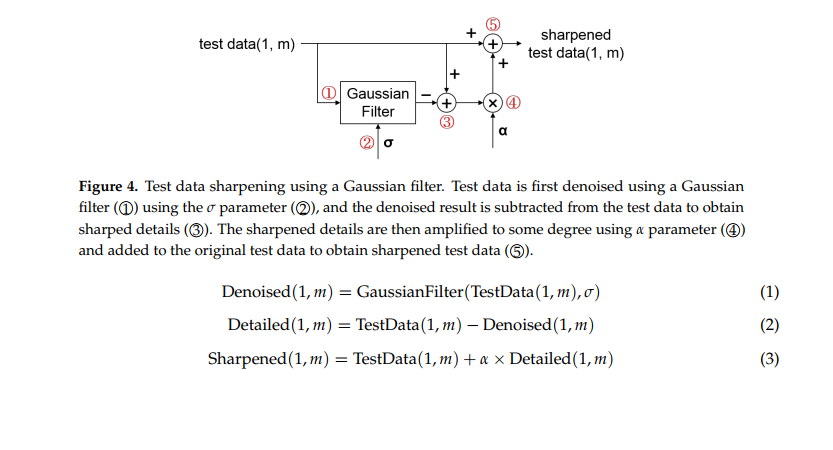

In [52]:
# refer: https://www.mdpi.com/1424-8220/18/4/1055
# refer: https://github.com/heeryoncho/sensors2018cnnhar

from IPython.display import Image
Image(filename='test sharpening.PNG')

In [53]:
def sharpened(data, sig=1,al=1):
    
    sharpend_data = []   
    for i in (range((data.shape[0]))):
        
        x_t=data[i]
        denoised_data = scipy.ndimage.gaussian_filter(input=x_t , sigma=sig)
        detailed_data = x_t - denoised_data
        after_sharpend = x_t + (al*denoised_data)
        
        sharpend_data.append(after_sharpend)     
        
    return np.array(sharpend_data)

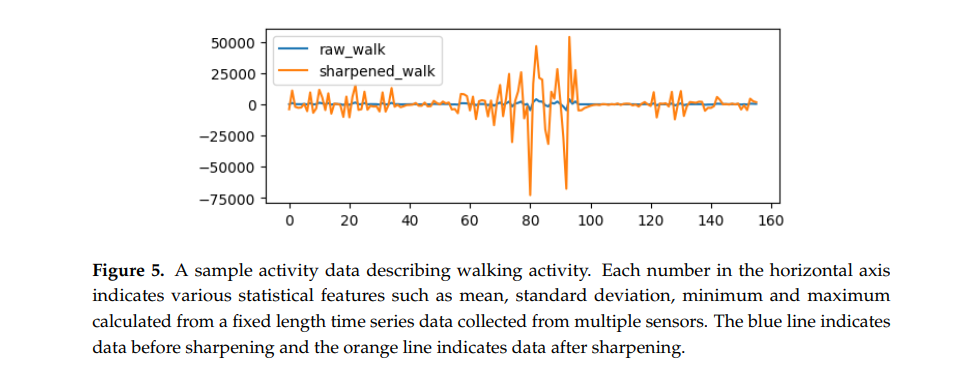

In [54]:
# refer: https://www.mdpi.com/1424-8220/18/4/1055
# refer: https://github.com/heeryoncho/sensors2018cnnhar

from IPython.display import Image
Image(filename='after sharpening.PNG')

In [55]:
X_test_sharpened=sharpened(data=X_test, sig=0.1, al=0.1)

testing(X_test_sharpened ,Y_test)

0.9219545300305395

### Finding right value of sigma and alpha for Test sharpening

In [56]:
# finding right value of sigma and alpha for Test sharpening
sigma_range = np.arange(5,10,1)
alpha_range = np.round(np.arange(0.01,0.31,0.01),3)

result_daframe = pd.DataFrame(np.zeros((sigma_range.shape[0],alpha_range.shape[0])),index=sigma_range,columns=alpha_range)

for sig in sigma_range:
    for al in alpha_range:        
        X_test_sharpened = sharpened(data = X_test, sig=sig  , al=al )
        result = testing(X_test_sharpened,Y_test)
        
        result_daframe.loc[sig][al]=result
        

In [57]:
result_daframe

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30
5,0.922294,0.921276,0.920937,0.919919,0.918901,0.917204,0.916525,0.916186,0.917204,0.916525,...,0.910078,0.910078,0.909739,0.909060,0.908721,0.908042,0.907363,0.906685,0.906006,0.904988
6,0.922294,0.921615,0.920937,0.920597,0.919240,0.918901,0.917204,0.916186,0.916525,0.916525,...,0.912114,0.911435,0.910417,0.910078,0.909739,0.909739,0.909739,0.908721,0.908042,0.907703
7,0.922294,0.921615,0.921276,0.920937,0.919919,0.918901,0.918561,0.916525,0.916865,0.916525,...,0.913132,0.912453,0.911435,0.911435,0.910757,0.909739,0.909399,0.909399,0.909399,0.909060
8,0.922294,0.921615,0.921276,0.920937,0.919919,0.918901,0.918901,0.917204,0.916525,0.916525,...,0.913132,0.913132,0.912453,0.911775,0.911096,0.910757,0.909399,0.909399,0.909399,0.909399
9,0.922294,0.921615,0.921276,0.920937,0.920258,0.919240,0.918901,0.917204,0.916525,0.916525,...,0.914489,0.913471,0.913471,0.912453,0.911096,0.910757,0.910417,0.909399,0.909399,0.908721


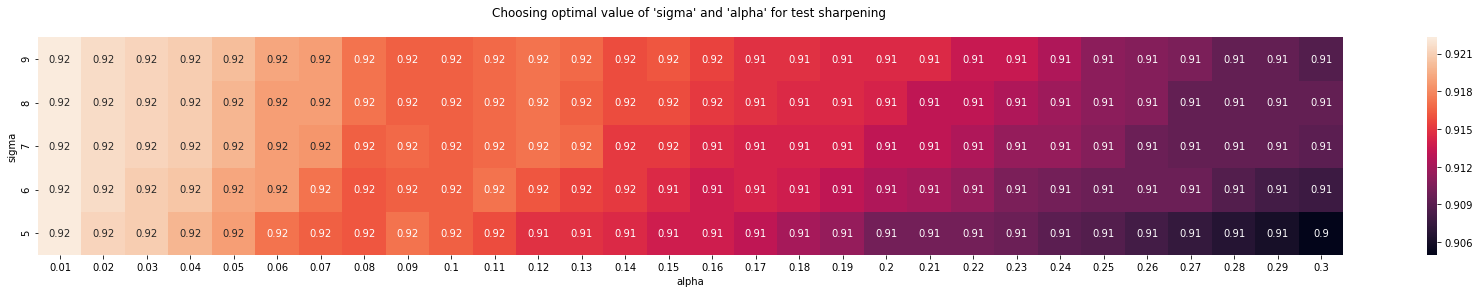

In [59]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(30,4))
sn.heatmap(result_daframe,annot=True,square=True)
plt.title("Choosing optimal value of 'sigma' and 'alpha' for test sharpening \n")
plt.ylabel("sigma")
plt.xlabel("alpha")
plt.ylim(0,len(result_daframe.index))
plt.show()

In [69]:
np.where(result_daframe==result_daframe.max(axis=0).max(axis=0))

(array([0, 1, 2, 3, 4], dtype=int64), array([0, 0, 0, 0, 0], dtype=int64))

In [72]:
# testing using optimal sigma and alpha value
X_test_sharpened=sharpened(data=X_test, sig=8, al=0.01)
testing(X_test_sharpened ,Y_test)

0.9222938581608415

## 4. LSTM using keras callbacks

In [9]:

from keras.callbacks import EarlyStopping, CSVLogger, TensorBoard,ReduceLROnPlateau


# reduce_learning_rate callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=10, min_lr=0.001)

# CSVLogger callback
csv_log=CSVLogger(filename = "training_log.csv")

# Early Stopper callback
early_stopper = EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=10,verbose=1,
                              mode='auto',baseline=None,restore_best_weights=True)


In [10]:
n_hidden=150

model = Sequential()
model.add(LSTM(n_hidden, kernel_initializer='glorot_normal',input_shape=(128, 9)))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
model.summary()
  
    
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               96000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 906       
Total params: 96,906
Trainable params: 96,906
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Training the model
model.fit(X_train,Y_train,
          batch_size=100,validation_data=(X_test, Y_test),epochs=100,callbacks=[early_stopper,csv_log])


Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 15s 2ms/step - loss: 1.3167 - accuracy: 0.4498 - val_loss: 1.0624 - val_accuracy: 0.5684
Epoch 2/100
7352/7352 [==============================] - 14s 2ms/step - loss: 1.0655 - accuracy: 0.5563 - val_loss: 0.9930 - val_accuracy: 0.6322
Epoch 3/100
7352/7352 [==============================] - 14s 2ms/step - loss: 0.7310 - accuracy: 0.7130 - val_loss: 0.8851 - val_accuracy: 0.6837
Epoch 4/100
7352/7352 [==============================] - 15s 2ms/step - loss: 0.8096 - accuracy: 0.6825 - val_loss: 0.7926 - val_accuracy: 0.6787
Epoch 5/100
7352/7352 [==============================] - 14s 2ms/step - loss: 0.7330 - accuracy: 0.6994 - val_loss: 0.6850 - val_accuracy: 0.7418
Epoch 6/100
7352/7352 [==============================] - 15s 2ms/step - loss: 0.5707 - accuracy: 0.7807 - val_loss: 0.5850 - val_accuracy: 0.7665
Epoch 7/100
7352/7352 [==============================] - 14s 2ms/step - los

In [12]:
model.evaluate(X_test,Y_test)

2947/2947 [==============================] - 5s 2ms/step


[0.2874682506673262, 0.9039701223373413]

## Query:

I have tried various LSTM Architecture and also the architecure suggested by appliedAI team but still I am not getting desire result .

Shall I submit abover model`s result  ?
